In [1]:
import sys, glob, os
sys.path.extend(glob.glob(os.path.join(os.path.expanduser("~"), ".ivy2/jars/*.jar")))
from sparkdl import readImages
from pyspark.sql.functions import lit

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
img_dir = "hdfs:///flower-classify/flowers"

#Read images and Create training & test DataFrames for transfer learning
daisy_df = readImages(img_dir + "/daisy").withColumn("label", lit(0))
dandelion_df = readImages(img_dir + "/dandelion").withColumn("label", lit(1))
#roses_df = readImages(img_dir + "/roses").withColumn("label", lit(2))
#sunflowers_df = readImages(img_dir + "/sunflowers").withColumn("label", lit(3))
#tulips_df = readImages(img_dir + "/tulips").withColumn("label", lit(4))
print("DATA READ.")

daisy_train, daisy_test = daisy_df.randomSplit([0.6, 0.4])
dandelion_train, dandelion_test = dandelion_df.randomSplit([0.6, 0.4])
#roses_train, roses_test = roses_df.randomSplit([0.6, 0.4])
#sunflowers_train, sunflowers_test = sunflowers_df.randomSplit([0.6, 0.4])
#tulips_train, tulips_test = tulips_df.randomSplit([0.6, 0.4])
print("DATA SPLITTED.")

#dataframe for training a classification model
train_df = daisy_train.unionAll(dandelion_train)#.unionAll(roses_train).unionAll(sunflowers_train).unionAll(tulips_train)
train_df = train_df.unionAll(train_df).unionAll(train_df).unionAll(train_df).unionAll(train_df).unionAll(train_df)
print("TRAIN DF PREPARED.")

#dataframe for testing the classification model
test_df = daisy_test.unionAll(dandelion_test)#.unionAll(roses_test).unionAll(sunflowers_test).unionAll(tulips_test)
test_df = train_df.unionAll(test_df).unionAll(test_df).unionAll(test_df).unionAll(test_df).unionAll(test_df)
print("TEST DF PREPARED.")

DATA READ.
DATA SPLITTED.
TRAIN DF PREPARED.
TEST DF PREPARED.


In [3]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from sparkdl import DeepImageFeaturizer

featurizer = DeepImageFeaturizer(inputCol="image", outputCol="features", modelName="InceptionV3")
lr = LogisticRegression(maxIter=5, regParam=0.05, elasticNetParam=0.3, labelCol="label")
p = Pipeline(stages=[featurizer, lr])
p_model = p.fit(train_df)

INFO:tensorflow:Froze 376 variables.
Converted 376 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

df = p_model.transform(test_df)
df.cache()
df.show()
predictionAndLabels = df.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Training set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

INFO:tensorflow:Froze 376 variables.
Converted 376 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.
+--------------------+--------------------+-----+--------------------+--------------------+--------------------+----------+
|            filePath|               image|label|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+-----+--------------------+--------------------+--------------------+----------+
|hdfs://student11:...|[RGB,240,180,3,[B...|    0|[0.0,0.0,0.0,0.04...|[1.83600497592549...|[0.86247553751359...|       0.0|
|hdfs://student11:...|[RGB,333,500,3,[B...|    0|[0.86700773239135...|[2.21497703780207...|[0.90158641467344...|       0.0|
|hdfs://student11:...|[RGB,281,500,3,[B...|    0|[0.0,0.3926008641...|[1.23982016374894...|[0.77553270961535...|       0.0|
|hdfs://student11:...|[RGB,240,320,3,[B...|    0|[0.0,0.0,0.045263...|[1.93596418149567...|[0.87390809628468..

In [1]:
# pandas_df = df.toPandas()

In [ ]:
#import pandas as pd
#from pandas_ml import ConfusionMatrix

#confusion_matrix = ConfusionMatrix(pandas_df.label, pandas_df.prediction)
#print('Training set accuracy: ' + str(confusion_matrix.stats()['overall']['Accuracy']))
#pandas_df[0:10]

In [ ]:
#import matplotlib.pyplot as plt
#confusion_matrix.plot()
#plt.show()

In [ ]:
#confusion_matrix.print_stats()

In [21]:
from IPython.display import Image
from IPython.core.display import HTML 
image_URL = "http://cdn2.stylecraze.com/wp-content/uploads/2013/11/Top-25-Most-Beautiful-Daisy-Flowers.jpg"
image_path = "/home/hduser/image.jpg"
image_hdfs_path = "hdfs:///flower-classify/tmp/image.jpg"

import urllib
urllib.urlretrieve (image_URL, image_path)

('/home/hduser/image.jpg', <httplib.HTTPMessage instance at 0x7fdc55581998>)

In [22]:
%%bash
hdfs dfs -copyFromLocal -f /home/hduser/image.jpg /flower-classify/tmp/

INFO:tensorflow:Froze 376 variables.
Converted 376 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.
+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|            filePath|               image|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|hdfs://student11:...|[RGB,810,720,3,[B...|[0.0,0.4824392199...|[1.88359342096004...|[0.86802332923498...|       0.0|
+--------------------+--------------------+--------------------+--------------------+--------------------+----------+



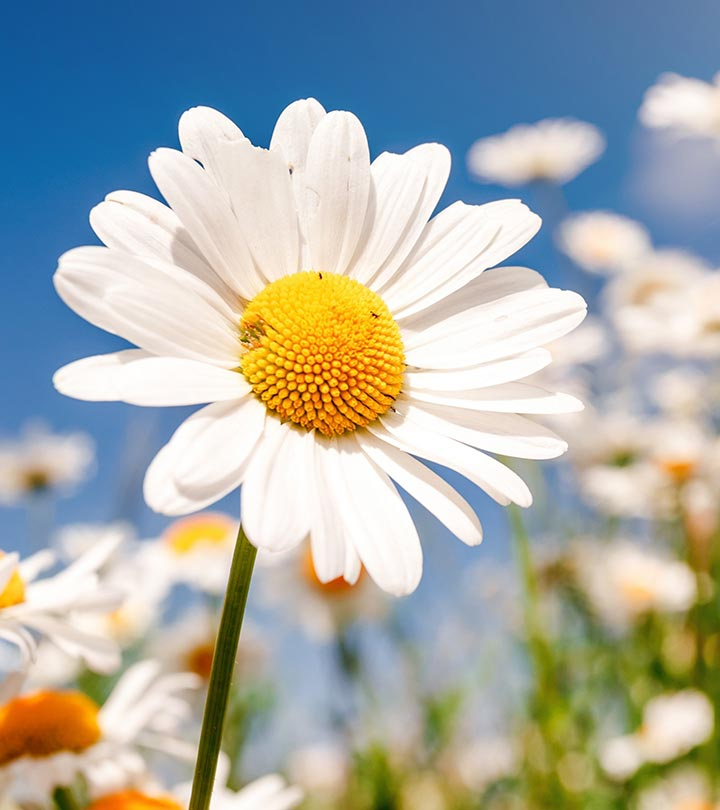

In [23]:
test_df = readImages(image_hdfs_path)
predictions = p_model.transform(test_df)
predictions.show()
Image(filename = image_path, width=400, height=400)